In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

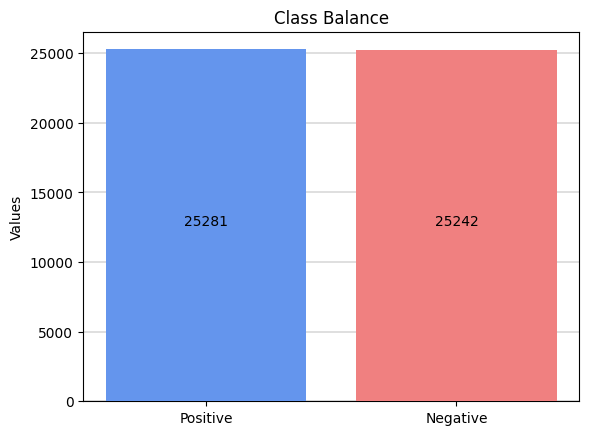

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,3), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 80% data train and 20% data test
x_unibitri = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unibitri,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 10000) (40418,)
(10105, 10000) (10105,)


In [8]:
tf_idf_len

10000

In [9]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
x_train.shape

(40418, 10000, 1)

In [11]:
y_train.shape

(40418,)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Menentukan model CNN
def cnn(x_train, y_train, x_test, y_test):

    model = Sequential()
    model.add(Input(shape=(tf_idf_len, 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    optimizer = Adam(learning_rate=0.001)
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])


    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 10000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,472,641 (78.10 MB)

 Trainable params: 20,472,641 (78.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - accuracy: 0.7129 - loss: 0.4971 - val_accuracy: 0.8190 - val_loss: 0.3735
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7801 - loss: 0.3871 - val_accuracy: 0.8303 - val_loss: 0.3497
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7957 - loss: 0.3591 - val_accuracy: 0.8330 - val_loss: 0.3533
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8114 - loss: 0.3321 - val_accuracy: 0.8112 - val_loss: 0.3888
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8263 - loss: 0.3011 - val_accuracy: 0.8259 - val_loss: 0.3702


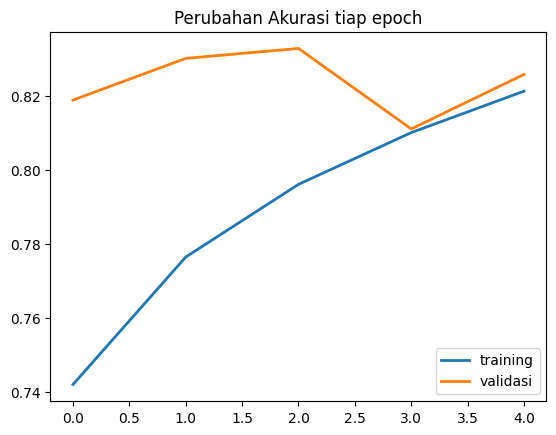

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.817615  0.836023  0.826717      5019
           1   0.834506  0.815965  0.825132      5086

    accuracy                       0.825928     10105
   macro avg   0.826061  0.825994  0.825924     10105
weighted avg   0.826117  0.825928  0.825919     10105



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 10000, 1)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,472,641 (78.10 MB)

 Trainable params: 20,472,641 (78.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.7177 - loss: 0.5001 - val_accuracy: 0.8238 - val_loss: 0.3671
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7841 - loss: 0.3840 - val_accuracy: 0.8239 - val_loss: 0.3579
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.8023 - loss: 0.3477 - val_accuracy: 0.8265 - val_loss: 0.3557
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.8227 - loss: 0.3190 - val_accuracy: 0.8273 - val_loss: 0.3642
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.8316 - loss: 0.2978 - val_accuracy: 0.8247 - val_loss: 0.3882
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.8374 - loss: 0.2778 - val_accuracy: 0.8249 - val_loss: 0.4175


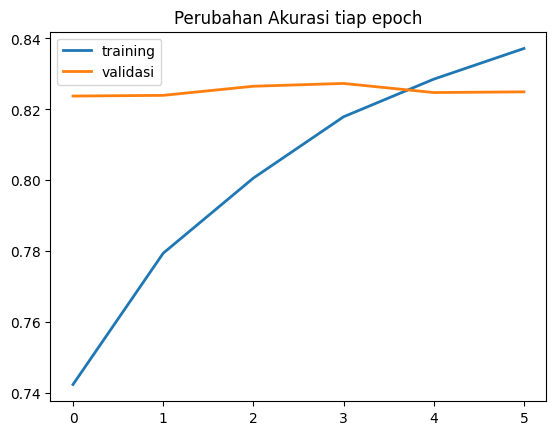

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.834087  0.808328  0.821006      5019
           1   0.816447  0.841329  0.828701      5086

    accuracy                       0.824938     10105
   macro avg   0.825267  0.824829  0.824854     10105
weighted avg   0.825209  0.824938  0.824879     10105



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 10000, 1)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 9996, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4998, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 639744)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │      20,471,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,472,641 (78.10 MB)

 Trainable params: 20,472,641 (78.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.7191 - loss: 0.4936 - val_accuracy: 0.8226 - val_loss: 0.3666
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7771 - loss: 0.3922 - val_accuracy: 0.8353 - val_loss: 0.3504
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.7940 - loss: 0.3585 - val_accuracy: 0.8269 - val_loss: 0.3609
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.8138 - loss: 0.3265 - val_accuracy: 0.8295 - val_loss: 0.3656
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8314 - loss: 0.3002 - val_accuracy: 0.8283 - val_loss: 0.3682


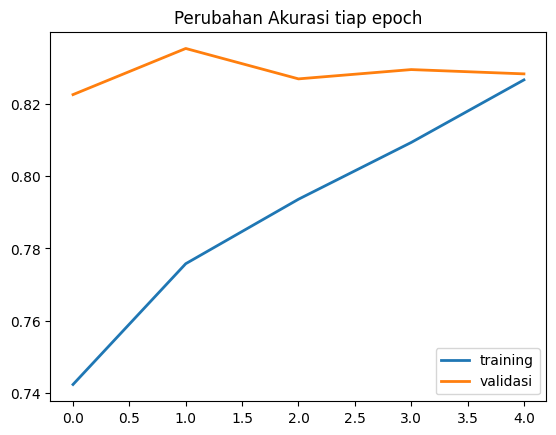

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.854032  0.789201  0.820338      5019
           1   0.806475  0.866890  0.835592      5086

    accuracy                       0.828303     10105
   macro avg   0.830254  0.828045  0.827965     10105
weighted avg   0.830096  0.828303  0.828015     10105



In [14]:
result = []
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8263895761174336
Average Precision : 0.8191429306744008
Average Recall    : 0.8413946782015991
Average F1-Score  : 0.8298083199575089
